In [1]:

# Install required dependencies
!pip install kaggle

# Set up the Kaggle API token (for private datasets)
import os

# Upload your kaggle.json file in the correct directory
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
!cp /kaggle/input/kagglejson/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d felicepollano/watermarked-not-watermarked-images -p /kaggle/working/
!unzip /kaggle/working/watermarked-not-watermarked-images.zip -d /kaggle/working/

cp: cannot stat '/kaggle/input/kagglejson/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/felicepollano/watermarked-not-watermarked-images
License(s): CC-BY-NC-SA-4.0
100%|████████████████████████████████████████▉| 698M/698M [00:05<00:00, 144MB/s]
100%|█████████████████████████████████████████| 698M/698M [00:05<00:00, 124MB/s]
Archive:  /kaggle/working/watermarked-not-watermarked-images.zip
  inflating: /kaggle/working/wm-nowm/.checkpoint  
  inflating: /kaggle/working/wm-nowm/train/no-watermark/IMG_3496bfree.jpg  
  inflating: /kaggle/working/wm-nowm/train/no-watermark/Warsaw-center-free-license-CC0.jpg  
  inflating: /kaggle/working/wm-nowm/train/no-watermark/adler-bird-bird-of-prey-raptor-56865.jpeg  
  inflating: /kaggle/working/wm-nowm/train/no-watermark/africa-animal-big-carnivore-41178.jpeg  
  inflating: /kaggle/working/wm-nowm/train/no-watermark/africa-south-africa-

In [2]:
import os
import cv2

# Define paths
dataset_dir = '/kaggle/working/wm-nowm'

# Function to preprocess images and skip corrupt ones
def preprocess_images(input_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for category in os.listdir(input_dir):
        category_path = os.path.join(input_dir, category)
        output_category_path = os.path.join(output_dir, category)

        if not os.path.exists(output_category_path):
            os.makedirs(output_category_path)

        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            output_img_path = os.path.join(output_category_path, img_name)

            try:
                img = cv2.imread(img_path)
                if img is None:  # Skip invalid images
                    print(f"Skipping corrupt file: {img_name}")
                    continue

                # Save the valid image to the output directory
                cv2.imwrite(output_img_path, img)

            except Exception as e:
                print(f"Error processing {img_name}: {e}")
                continue

# Preprocess training and validation data
train_dir = os.path.join(dataset_dir, 'train')
valid_dir = os.path.join(dataset_dir, 'valid')

preprocessed_train_dir = '/kaggle/working/new/train'
preprocessed_valid_dir = '/kaggle/working/new/valid'

preprocess_images(train_dir, preprocessed_train_dir)
preprocess_images(valid_dir, preprocessed_valid_dir)

Found 24987 files belonging to 2 classes.
Found 6588 files belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/50
781/781 - 31s - 39ms/step - accuracy: 0.5893 - loss: 0.7200 - val_accuracy: 0.6988 - val_loss: 0.5718
Epoch 2/50
781/781 - 12s - 15ms/step - accuracy: 0.7710 - loss: 0.4773 - val_accuracy: 0.8232 - val_loss: 0.3941
Epoch 3/50
781/781 - 12s - 15ms/step - accuracy: 0.8199 - loss: 0.4018 - val_accuracy: 0.8283 - val_loss: 0.3746
Epoch 4/50
781/781 - 12s - 15ms/step - accuracy: 0.8460 - loss: 0.3582 - val_accuracy: 0.8490 - val_loss: 0.3386
Epoch 5/50
781/781 - 12s - 15ms/step - accuracy: 0.8562 - loss: 0.3378 - val_accuracy: 0.8594 - val_loss: 0.3274
Epoch 6/50
781/781 - 12s - 15ms/step - accuracy: 0.8665 - loss: 0.3153 - val_accuracy: 0.8604 - val_loss: 0.3266
Epoch 7/50
781/781 - 12s - 15ms/step - accuracy: 0.8761 - loss: 0.2975 - val_accuracy: 0.8833 - val_loss: 0.2873
Epoch 8/50
781/781 - 12s - 15ms/step - accuracy: 0.8856 - loss: 0.2847 - val_accuracy: 0.8692 - val_loss: 0.3294
Epoch 9/50
781/781 - 12s - 15ms/step - accuracy: 0.8924 - loss: 0.2657 - val_accuracy: 0.8692 - 

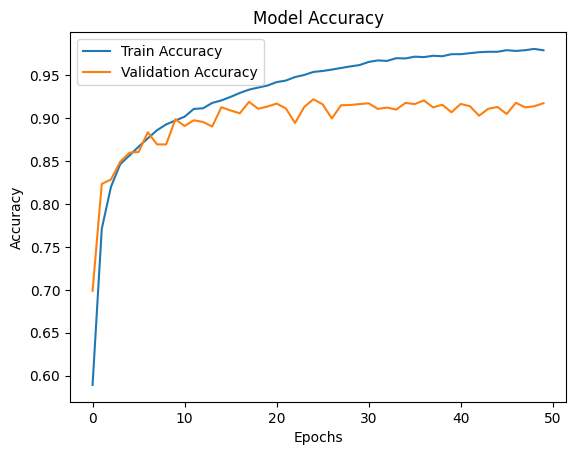

In [4]:
import os
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, Concatenate, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from scipy.stats import entropy

# Enable mixed precision training
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Dataset paths
dataset_dir = "/kaggle/working/new"  # Update this to match your Kaggle dataset folder
train_dir = os.path.join(dataset_dir, 'train')
valid_dir = os.path.join(dataset_dir, 'valid')

# Preprocessing function
def preprocess_image(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Rescale to range [0, 1]
    return image, label

# Feature calculation for a single image
def calculate_features(image):
    """Calculate Kullback-Leibler Divergence (KLD) and entropy for a single image."""
    # Compute histograms for each channel
    hist_r = np.histogram(image[:, :, 0], bins=256, range=(0, 1), density=True)[0] + 1e-10
    hist_g = np.histogram(image[:, :, 1], bins=256, range=(0, 1), density=True)[0] + 1e-10
    hist_b = np.histogram(image[:, :, 2], bins=256, range=(0, 1), density=True)[0] + 1e-10

    # Uniform reference distribution
    reference_hist = np.ones(256) / 256

    # Calculate KLD for each channel
    kld_r = entropy(hist_r, reference_hist)
    kld_g = entropy(hist_g, reference_hist)
    kld_b = entropy(hist_b, reference_hist)
    kld_mean = np.mean([kld_r, kld_g, kld_b])

    # Calculate entropy for each channel
    entropy_r = entropy(hist_r)
    entropy_g = entropy(hist_g)
    entropy_b = entropy(hist_b)
    entropy_mean = np.mean([entropy_r, entropy_g, entropy_b])

    return kld_mean, entropy_mean

# Load and preprocess dataset using tf.data API
batch_size = 32  # Reduced to save memory
img_size = (128, 128)  # Reduced image size

def get_data_generator(dataset_dir):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        dataset_dir,
        image_size=img_size,
        batch_size=batch_size,
        color_mode='rgb',
        shuffle=True
    ).map(preprocess_image).prefetch(tf.data.AUTOTUNE)  # Prefetch for performance
    return dataset

train_dataset = get_data_generator(train_dir)
valid_dataset = get_data_generator(valid_dir)

# Prepare data with KLD and entropy
def add_features_to_dataset(dataset):
    kld_features = []
    entropy_features = []
    all_images = []
    all_labels = []

    for images, labels in dataset:
        for image in images:
            kld, ent = calculate_features(image.numpy())
            kld_features.append(kld)
            entropy_features.append(ent)
            all_images.append(image.numpy())
        all_labels.extend(labels.numpy())

    # Normalize features
    kld_features = np.array(kld_features)
    entropy_features = np.array(entropy_features)
    kld_features = (kld_features - np.min(kld_features)) / (np.max(kld_features) - np.min(kld_features))
    entropy_features = (entropy_features - np.min(entropy_features)) / (np.max(entropy_features) - np.min(entropy_features))

    return np.array(all_images), kld_features, entropy_features, np.array(all_labels)

# Extract features for both train and validation datasets
train_images, train_kld, train_entropy, train_labels = add_features_to_dataset(train_dataset)
valid_images, valid_kld, valid_entropy, valid_labels = add_features_to_dataset(valid_dataset)

# Define the combined CNN model
input_image = Input(shape=(128, 128, 3), name="image_input")
input_kld = Input(shape=(1,), name="kld_input")
input_entropy = Input(shape=(1,), name="entropy_input")

# Convolutional Blocks
x = Conv2D(32, (3, 3), padding='same')(input_image)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(256, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.8)(x)
x = Dense(256, activation='elu')(x)
x = BatchNormalization()(x)
x = Dropout(0.8)(x)
x = Dense(128, activation='elu')(x)

# Combine CNN output with KLD and entropy inputs
combined = Concatenate()([x, input_kld, input_entropy])
output = Dense(1, activation='sigmoid', dtype='float32')(combined)

model = Model(inputs=[input_image, input_kld, input_entropy], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    [train_images, train_kld, train_entropy], train_labels,
    validation_data=([valid_images, valid_kld, valid_entropy], valid_labels),
    epochs=50,
    verbose=2
)

# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
